# **Housing Price Prediction - Zameen.com**

### **Introduction**

This project focuses on predicting housing prices using a dataset scraped from Zameen.com, a popular real estate website in Pakistan. The dataset includes key features such as:
- The area in square feet 
- The number of bedrooms
- The number of bathrooms
- Listed price of the properties

**Objective:** To build a robust machine learning model that can accurately predict the prices of houses based on these features. 

**Key Steps in the Workflow:**
- Data Cleaning: Removing rows with missing or erroneous values.
- Feature Engineering: Combining related features, such as merging the number of bedrooms and bathrooms, to improve model performance.
- Exploratory Data Analysis: Checking for multicollinearity and correlations to better understand feature relationships.
- Modeling: Splitting the data into training and testing sets, and then applying machine learning models using a pipeline that includes outlier treatment and standardization.
- Model Optimization: Using grid search to fine-tune the model parameters for the best predictive performance.

## **1. Import Necessary Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats.mstats import winsorize
from sklearn.base import BaseEstimator, TransformerMixin
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
import dill as pickle

RANDOM_STATE = 42

## **2. Data Exploration**

In [2]:
df = pd.read_csv("C:/Users/HP/Downloads/zameen.xls", sep='|')
df.head()

,city,location,area_sq_ft,num_of_bedrooms,num_of_bathrooms,price_in_rupees
0,Lahore,"OLC - Block A, Overseas Low Cost",1362.0,3,4,15500000
1,Lahore,"Park View City, Lahore",1362.0,4,3,20000000
2,Lahore,"DHA Phase 8 - Ex Air Avenue, DHA Phase 8",2995.0,4,5,56000000
3,Lahore,"Bahria Town - Jasmine Block, Bahria Town - Sec...",2723.0,5,6,31000000
4,Lahore,"DHA Phase 6, DHA Defence",10890.0,5,6,380000000


In [3]:
df.describe()

,area_sq_ft,num_of_bedrooms,num_of_bathrooms,price_in_rupees
count,9761.000000,9761.000000,9761.000000,9.761000e+03
mean,3044.041799,4.662330,4.694499,6.018582e+07
std,3172.571324,1.842548,1.722292,1.085246e+08
min,0.000000,0.000000,0.000000,2.000000e+06
25%,1362.000000,4.000000,4.000000,1.850000e+07
50%,2250.000000,5.000000,5.000000,3.250000e+07
75%,3600.000000,6.000000,6.000000,6.250000e+07
max,153004.000000,11.000000,10.000000,2.500000e+09


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9761 entries, 0 to 9760
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   city              9761 non-null   object 
 1   location          9761 non-null   object 
 2   area_sq_ft        9761 non-null   float64
 3   num_of_bedrooms   9761 non-null   int64  
 4   num_of_bathrooms  9761 non-null   int64  
 5   price_in_rupees   9761 non-null   int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 457.7+ KB


In [5]:
df.shape

(9761, 6)

### a. Identifying and removing Null values

In [6]:
df.isna().any(axis=0)

city                False
location            False
area_sq_ft          False
num_of_bedrooms     False
num_of_bathrooms    False
price_in_rupees     False
dtype: bool

In [7]:
(df==0).sum()

city                  0
location              0
area_sq_ft           35
num_of_bedrooms     431
num_of_bathrooms    713
price_in_rupees       0
dtype: int64

In [8]:
(df=='').sum()

city                0
location            0
area_sq_ft          0
num_of_bedrooms     0
num_of_bathrooms    0
price_in_rupees     0
dtype: int64

In [9]:
# Replace 0 with np.nan 
df[['area_sq_ft', 'num_of_bedrooms', 'num_of_bathrooms']] = df[['area_sq_ft', 'num_of_bedrooms', 'num_of_bathrooms']].replace(0, np.nan)

In [10]:
df.isna().sum()

city                  0
location              0
area_sq_ft           35
num_of_bedrooms     431
num_of_bathrooms    713
price_in_rupees       0
dtype: int64

In [11]:
# Drop rows with null values in the specified columns "area_sq_ft","num_of_bedrooms","num_of_bathrooms"
df.dropna(subset = ['area_sq_ft', 'num_of_bedrooms', 'num_of_bathrooms'], inplace = True)

### b. Identifying Outliers

In [12]:
# Combining Num of bedrooms and bathrooms
df['num_of_bed_bath'] = df['num_of_bedrooms'] + df['num_of_bathrooms']

In [13]:
df.drop(columns=['city','location','num_of_bedrooms','num_of_bathrooms'],axis=1, inplace = True)

In [14]:
df.head()

,area_sq_ft,price_in_rupees,num_of_bed_bath
0,1362.0,15500000,7.0
1,1362.0,20000000,7.0
2,2995.0,56000000,9.0
3,2723.0,31000000,11.0
4,10890.0,380000000,11.0


In [15]:
# Calculate outliers
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

lower_bound =  Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

((df < lower_bound) | (df > upper_bound)).sum().sort_values(ascending = False)

price_in_rupees    777
area_sq_ft         431
num_of_bed_bath      1
dtype: int64

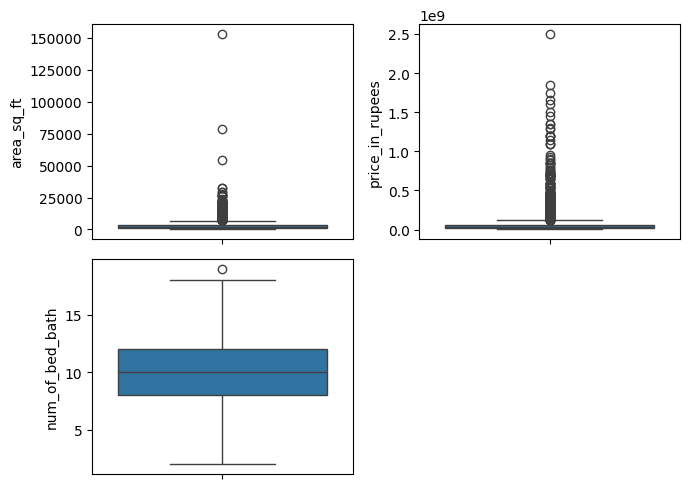

In [16]:
# Plotting the outliers
columns_with_outliers = ['area_sq_ft', 'price_in_rupees', 'num_of_bed_bath']

plt.figure(figsize = (7,5))
for i,column in enumerate(columns_with_outliers):
    plt.subplot(2, 2, i+1)
    sns.boxplot(data = df, y= column)

plt.tight_layout()
plt.show()

In [17]:
def apply_winsorize(X, limits=(0.05,0.05)):
    
    X_winsorized = np.array(X, dtype=float)
    X_winsorized[:,0] = winsorize(X_winsorized[:,0], limits=limits)
    
    return X_winsorized

In [18]:
# Custom winsorizer transformer to remove outliers
# class Winsonizer(BaseEstimator, TransformerMixin):
#     def __init__(self, limits=(0.05, 0.05)):
#         self.limits = limits
        
#     def fit(self, X, y=None):
#         return self
        
#     def transform(self, X):
#         X_winsorized = X.copy()
        
#         for col in range(X_winsorized.shape[1]):
#             X_winsorized.iloc[:,col] = winsorize(X_winsorized.iloc[:,col], limits = self.limits)
#         return X_winsorized

### **c. Checking for correlation and multi-collinearity**

<Axes: >

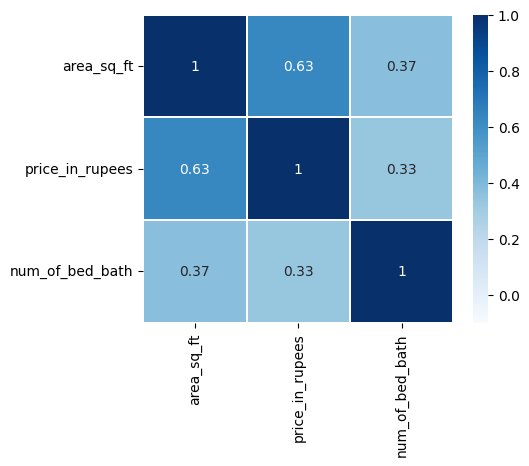

In [19]:
correlation_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(5,4))
sns.heatmap(correlation_matrix, annot = True, linewidth = 0.3, cmap=plt.cm.Blues, vmin=-0.1)

In [20]:
def calculate_vif(X):
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return (vif)

- VIF starts at 1 and has no upper limit
- VIF = 1, no correlation between the independent variable and the other variables
- VIF exceeding 5 or 10 indicates high multicollinearity between this independent variable and the others

In [21]:
X = df[['area_sq_ft', 'price_in_rupees', 'num_of_bed_bath']]
calculate_vif(X)

,variables,VIF
0,area_sq_ft,3.374364
1,price_in_rupees,2.243566
2,num_of_bed_bath,2.185075


### **d. Visualizations**

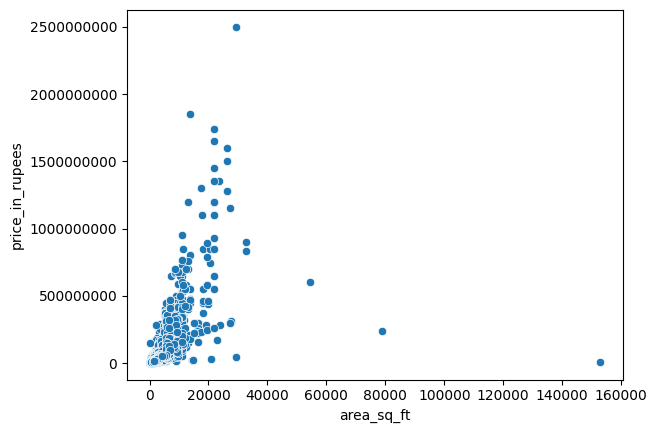

In [22]:
# # Plot area vs price
plt.ticklabel_format(style='plain')
sns.scatterplot(x = 'area_sq_ft', y = 'price_in_rupees', data=df)
plt.show()

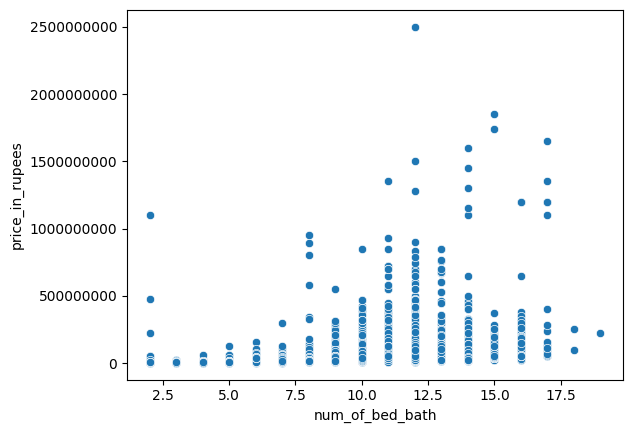

In [23]:
# # Plot number of bedroom and bathroom vs price
plt.ticklabel_format(style='plain')
sns.scatterplot(x = 'num_of_bed_bath', y = 'price_in_rupees', data=df)
plt.show()

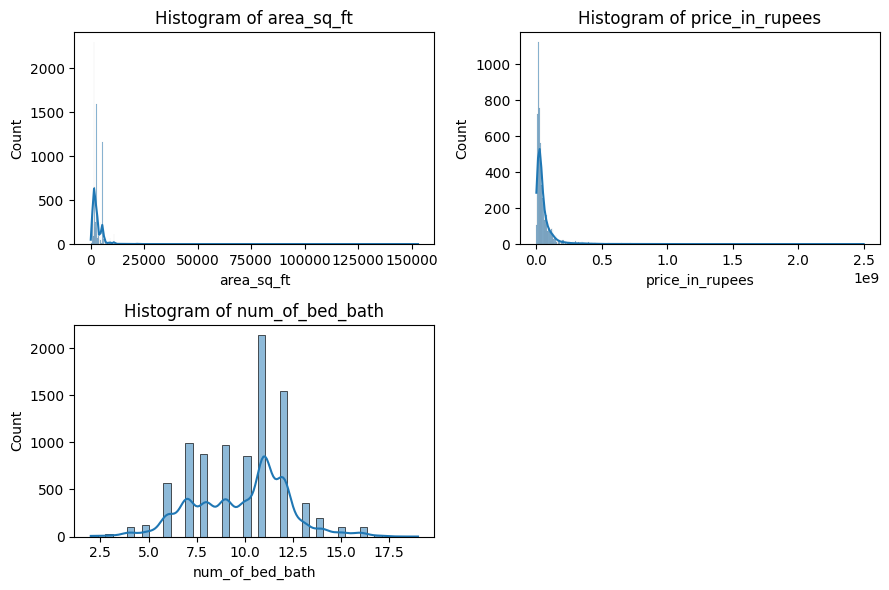

In [24]:
plt.figure(figsize = (9,6))

for i, col in enumerate(df.columns):
    plt.subplot(2,2,i+1)
    sns.histplot(data = df, x = col, kde = True)
    plt.title(f"Histogram of {col}")
    
plt.tight_layout()
plt.show()

## **3. Splitting the Dataset**

In [25]:
X = df.drop(columns = ['price_in_rupees'],  axis = 1)
y = df['price_in_rupees']
y_log = np.log(y)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size = 0.2, random_state = RANDOM_STATE)

print(f"X_train shape {X_train.shape}")
print(f"Y_train shape {y_train.shape}")
print(f"X_test shape {X_test.shape}")
print(f"Y_test shape {y_test.shape}")

X_train shape (7203, 2)
Y_train shape (7203,)
X_test shape (1801, 2)
Y_test shape (1801,)


In [27]:
X_train.head()

,area_sq_ft,num_of_bed_bath
3339,2178.0,11.0
1324,2115.0,6.0
2948,5990.0,16.0
751,5445.0,11.0
3975,1089.0,8.0


## **4. Creating Pipeline**


In [28]:
# trf1 = ColumnTransformer([
#     ("winsonizer", winsorize(0.05,0.05), [0])
# ], remainder = "passthrough")

trf1 = ColumnTransformer([
    ("winsorizer", FunctionTransformer(apply_winsorize, validate=False, kw_args={'limits': (0.05, 0.05)}), [0]),
], remainder = "passthrough")

In [29]:
trf2 = ColumnTransformer([
    ('scale', StandardScaler(), slice(0,2))
], remainder = "passthrough")

### **a. Ridge Regression**

In [30]:
trf3 = Ridge(random_state = RANDOM_STATE) 

In [31]:
pipeline_1 = Pipeline([
    ('trf1', trf1),
    ('trf2', trf2),
    ('trf3', trf3),
])

In [32]:
pipeline_1.fit(X_train, y_train)

Pipeline(steps=[('trf1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('winsorizer',
                                                  FunctionTransformer(func=<function apply_winsorize at 0x00000208801CD300>,
                                                                      kw_args={'limits': (0.05,
                                                                                          0.05)}),
                                                  [0])])),
                ('trf2',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scale', StandardScaler(),
                                                  slice(0, 2, None))])),
                ('trf3', Ridge(random_state=42))])

In [33]:
y_pred_1 = pipeline_1.predict(X_test)

r2_score = r2_score(y_test, y_pred_1)
print(f"r2 score: {r2_score}")

rmse = np.sqrt(mean_squared_error(y_test, y_pred_1))
print(f"Root mean square error: {rmse}")

mae_1 = mean_absolute_error(y_test, y_pred_1)
print(f"Mean absolute error: {mae_1}")

r2 score: 0.7578456701904434
Root mean square error: 0.4371266351989278
Mean absolute error: 0.3245615016228147


### **Hyperparameter Tuning**

In [34]:
params = {'trf3__alpha': np.arange(0, 1, 0.01)}
cv = KFold(n_splits = 10)

grid_search = GridSearchCV(pipeline_1, params, cv=cv, scoring='neg_mean_absolute_error', n_jobs = -1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('trf1',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('winsorizer',
                                                                         FunctionTransformer(func=<function apply_winsorize at 0x00000208801CD300>,
                                                                                             kw_args={'limits': (0.05,
                                                                                                                 0.05)}),
                                                                         [0])])),
                                       ('trf2',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('sc...
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99])},
             scoring='neg_mean_absolute_error')

In [35]:
print("Best parameters : ",grid_search.best_params_)
print("Best MAE: ", grid_search.best_score_)

Best parameters :  {'trf3__alpha': 0.99}
Best MAE:  -0.3265490676859206


### **b. XGB Regressor**

In [36]:
# These parameters were found using grid search
trf4 = XGBRegressor(max_depth = 6, min_child_weight = 2) 

In [37]:
pipeline_2 = Pipeline([
    ('trf1', trf1),
    ('trf2', trf2),
    ('trf4', trf4),
])

In [38]:
pipeline_2.fit(X_train, y_train)

Pipeline(steps=[('trf1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('winsorizer',
                                                  FunctionTransformer(func=<function apply_winsorize at 0x00000208801CD300>,
                                                                      kw_args={'limits': (0.05,
                                                                                          0.05)}),
                                                  [0])])),
                ('trf2',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scale', StandardScaler(),
                                                  slice(0, 2, None))])),
                ('trf4',
                 XGBRegressor(base_score=Non...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=6, max_leaves=None, min_child_weight=2,
                              missing=nan, monotone_constraints=None,
                              multi_strategy=None, n_estimators=None,
                              n_jobs=None, num_parallel_tree=None,
                              random_state=None, ...))])

In [39]:
y_pred_2 = pipeline_2.predict(X_test)

# r2_score_xgb = r2_score(y_test, y_pred_2)
# print(f"r2 score: {r2_score_xgb}")

rmse = np.sqrt(mean_squared_error(y_test, y_pred_2))
print(f"Root mean square error: {rmse}")

mae_2 = mean_absolute_error(y_test, y_pred_2)
print(f"Mean absolute error: {mae_2}")

Root mean square error: 0.3963344324814342
Mean absolute error: 0.2799062504935783


### **Hyperparameter Tuning**

In [40]:
# xgb_params = {
#     'trf4__max_depth': range(1,15,1),
#     'trf4__min_child_weight': range(1,8)
# }

xgb_params = {
    'trf4__learning_rate': [0.03,0.02,0.01,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55],
    'trf4__n_estimators': range(200,350,10)
}

cv = KFold(n_splits = 10)
xgb_grid_search = GridSearchCV(pipeline_2, xgb_params, cv=cv, scoring='neg_mean_absolute_error', n_jobs = -1)
xgb_grid_search.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('trf1',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('winsorizer',
                                                                         FunctionTransformer(func=<function apply_winsorize at 0x00000208801CD300>,
                                                                                             kw_args={'limits': (0.05,
                                                                                                                 0.05)}),
                                                                         [0])])),
                                       ('trf2',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('sc...
                                                     max_leaves=None,
                                                     min_child_weight=2,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'trf4__learning_rate': [0.03, 0.02, 0.01, 0.1, 0.15,
                                                 0.2, 0.25, 0.3, 0.35, 0.4,
                                                 0.45, 0.5, 0.55],
                         'trf4__n_estimators': range(200, 350, 10)},
             scoring='neg_mean_absolute_error')

In [41]:
print("Best parameters: ",xgb_grid_search.best_params_)
print("Best MAE: ", xgb_grid_search.best_score_)

Best parameters:  {'trf4__learning_rate': 0.15, 'trf4__n_estimators': 240}
Best MAE:  -0.2798965124359603


## **5. Exporting the pipeline**

In [42]:
pickle.dump(pipeline_2, open('house_price_pred_pipeline.pkl','wb'))